## Importowanie Biblotek

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

%load_ext  tensorboard

import matplotlib.pyplot as plt
from skimage import color, exposure

from sklearn.metrics import accuracy_score

## Wczytanie danych

In [3]:
cd 'drive/My Drive/Colab Notebooks/matrix/dw_matrix_road_sign'

/content/drive/My Drive/Colab Notebooks/matrix/dw_matrix_road_sign


In [4]:
train = pd.read_pickle('data/train.p')
test = pd.read_pickle('data/test.p')

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [5]:
y_train

array([41, 41, 41, ..., 25, 25, 25], dtype=uint8)

In [6]:
to_categorical( y_train )[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [7]:
 if (y_train.ndim == 1):
     y_train = to_categorical(y_train)

 if (y_test.ndim == 1):
     y_test = to_categorical(y_test)

In [8]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [9]:
model = Sequential([
    Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape ),
    
    Flatten(),
    Dense(num_classes, activation = 'softmax'),
])

# model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
model.fit(X_train, y_train)

1088/1088 [==============================] - 4s 3ms/step - loss: 10.1558 - accuracy: 0.7742


In [10]:
def get_ccn_v1(input_shape, num_classes):
    return Sequential([
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape ),
        
        Flatten(),
        Dense(num_classes, activation = 'softmax'),
    ])

def train_model(model, X_train, y_train, params_fit = {}):
    model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1)
    model.fit(
        X_train, 
        y_train,
        batch_size = params_fit.get('batch_size', 128),
        epochs = params_fit.get('epochs', 5),
        verbose = params_fit.get('verbose', 1),
        validation_data = params_fit.get('validation_data', (X_train, y_train)),
        callbacks = [ tensorboard_callback ]
    )

    return model


In [11]:
model = get_ccn_v1(input_shape, num_classes)
model_trained = train_model(model, X_train, y_train)

Epoch 1/5
272/272 [==============================] - 3s 12ms/step - loss: 28.6390 - accuracy: 0.7459 - val_loss: 0.2569 - val_accuracy: 0.9310
Epoch 2/5
272/272 [==============================] - 3s 10ms/step - loss: 0.1973 - accuracy: 0.9522 - val_loss: 0.1355 - val_accuracy: 0.9653
Epoch 3/5
272/272 [==============================] - 3s 10ms/step - loss: 0.1334 - accuracy: 0.9684 - val_loss: 0.1057 - val_accuracy: 0.9736
Epoch 4/5
272/272 [==============================] - 3s 11ms/step - loss: 0.1102 - accuracy: 0.9744 - val_loss: 0.1017 - val_accuracy: 0.9721
Epoch 5/5
272/272 [==============================] - 3s 11ms/step - loss: 0.1280 - accuracy: 0.9718 - val_loss: 0.0843 - val_accuracy: 0.9813


In [12]:
df = pd.read_csv('data/signnames.csv')
labels_dict = df.to_dict()['b']

In [13]:
def predict(model_trained, X_test, y_test, scoring = accuracy_score):
    y_test_norm = np.argmax(y_test, axis = 1)

    y_pred_prob = model_trained.predict(X_test)
    y_pred = np.argmax( y_pred_prob, axis = 1)

    return scoring(y_test_norm, y_pred)


In [14]:
predict(model_trained, X_test, y_test)

0.8340136054421768

In [18]:
def train_and_predict(model):
    model_trained = train_model(model, X_train, y_train)

    return predict(model_trained, X_test, y_test)

In [20]:
def get_ccn_v2(input_shape, num_classes):
    return Sequential([
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape ),
        MaxPool2D(),
        Dropout(0.3),

        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(),
        Dropout(0.3),

        Flatten(),
        
        Dense(1024, activation = 'relu'),
        Dropout(0.3),

        Dense(num_classes, activation = 'softmax'),
    ])


train_and_predict( get_ccn_v2(input_shape, num_classes) )

Epoch 1/5
272/272 [==============================] - 3s 11ms/step - loss: 5.7304 - accuracy: 0.2549 - val_loss: 1.7155 - val_accuracy: 0.5042
Epoch 2/5
272/272 [==============================] - 3s 10ms/step - loss: 1.6388 - accuracy: 0.5112 - val_loss: 0.9437 - val_accuracy: 0.7416
Epoch 3/5
272/272 [==============================] - 3s 10ms/step - loss: 0.9898 - accuracy: 0.6946 - val_loss: 0.4384 - val_accuracy: 0.8857
Epoch 4/5
272/272 [==============================] - 3s 10ms/step - loss: 0.6095 - accuracy: 0.8162 - val_loss: 0.2195 - val_accuracy: 0.9476
Epoch 5/5
272/272 [==============================] - 3s 10ms/step - loss: 0.4269 - accuracy: 0.8711 - val_loss: 0.1159 - val_accuracy: 0.9752


0.891156462585034

In [27]:
def get_ccn_v3(input_shape, num_classes):
    return Sequential([
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape ),
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(),
        Dropout(0.3),

        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(),
        Dropout(0.3),

        Flatten(),
        
        Dense(1024, activation = 'relu'),
        Dropout(0.3),

        Dense(num_classes, activation = 'softmax'),
    ])


train_and_predict( get_ccn_v3(input_shape, num_classes) )

Epoch 1/5
272/272 [==============================] - 4s 16ms/step - loss: 1.9656 - accuracy: 0.5965 - val_loss: 0.1895 - val_accuracy: 0.9574
Epoch 2/5
272/272 [==============================] - 4s 14ms/step - loss: 0.4018 - accuracy: 0.8835 - val_loss: 0.0718 - val_accuracy: 0.9838
Epoch 3/5
272/272 [==============================] - 4s 14ms/step - loss: 0.2279 - accuracy: 0.9334 - val_loss: 0.0465 - val_accuracy: 0.9888
Epoch 4/5
272/272 [==============================] - 4s 14ms/step - loss: 0.1567 - accuracy: 0.9553 - val_loss: 0.0259 - val_accuracy: 0.9940
Epoch 5/5
272/272 [==============================] - 4s 14ms/step - loss: 0.1272 - accuracy: 0.9635 - val_loss: 0.0187 - val_accuracy: 0.9949


0.9705215419501134

In [28]:
def get_ccn_v4(input_shape, num_classes):
    return Sequential([
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape ),
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        MaxPool2D(),
        Dropout(0.3),

        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(),
        Dropout(0.3),

        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(),
        Dropout(0.3),

        Flatten(),
        
        Dense(1024, activation = 'relu'),
        Dropout(0.3),

        Dense(num_classes, activation = 'softmax'),
    ])

train_and_predict( get_ccn_v4(input_shape, num_classes) )

Epoch 1/5
272/272 [==============================] - 5s 17ms/step - loss: 2.5048 - accuracy: 0.3170 - val_loss: 0.9252 - val_accuracy: 0.7305
Epoch 2/5
272/272 [==============================] - 4s 16ms/step - loss: 0.8323 - accuracy: 0.7356 - val_loss: 0.2325 - val_accuracy: 0.9212
Epoch 3/5
272/272 [==============================] - 4s 16ms/step - loss: 0.4001 - accuracy: 0.8741 - val_loss: 0.0907 - val_accuracy: 0.9718
Epoch 4/5
272/272 [==============================] - 4s 16ms/step - loss: 0.2646 - accuracy: 0.9183 - val_loss: 0.0596 - val_accuracy: 0.9830
Epoch 5/5
272/272 [==============================] - 4s 16ms/step - loss: 0.1925 - accuracy: 0.9413 - val_loss: 0.0318 - val_accuracy: 0.9914


0.9673469387755103

In [29]:
def get_ccn_v5(input_shape, num_classes):
    return Sequential([
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape ),
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        MaxPool2D(),
        Dropout(0.3),

        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(),
        Dropout(0.3),

        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(),
        Dropout(0.3),

        Flatten(),
        
        Dense(1024, activation = 'relu'),
        Dropout(0.3),
        
        Dense(1024, activation = 'relu'),
        Dropout(0.3),

        Dense(num_classes, activation = 'softmax'),
    ])

train_and_predict( get_ccn_v5(input_shape, num_classes) )

Epoch 1/5
272/272 [==============================] - 5s 18ms/step - loss: 2.6503 - accuracy: 0.2843 - val_loss: 0.7427 - val_accuracy: 0.7738
Epoch 2/5
272/272 [==============================] - 5s 17ms/step - loss: 0.6649 - accuracy: 0.7958 - val_loss: 0.1622 - val_accuracy: 0.9563
Epoch 3/5
272/272 [==============================] - 5s 17ms/step - loss: 0.3204 - accuracy: 0.9041 - val_loss: 0.0812 - val_accuracy: 0.9787
Epoch 4/5
272/272 [==============================] - 5s 17ms/step - loss: 0.2129 - accuracy: 0.9380 - val_loss: 0.0489 - val_accuracy: 0.9855
Epoch 5/5
272/272 [==============================] - 5s 17ms/step - loss: 0.1697 - accuracy: 0.9506 - val_loss: 0.0355 - val_accuracy: 0.9903


0.9693877551020408

In [47]:
X_train_gray = color.rgb2gray(X_train).reshape(-1, 32, 32, 1)
X_test_gray = color.rgb2gray(X_test).reshape(-1, 32, 32, 1)

In [49]:
model = get_ccn_v5((32, 32, 1), num_classes)
model_trained =  train_model(model, X_train_gray, y_train, params_fit = {})
predict(model_trained, X_test_gray, y_test)

Epoch 1/5
272/272 [==============================] - 5s 18ms/step - loss: 2.5878 - accuracy: 0.2627 - val_loss: 0.8631 - val_accuracy: 0.7360
Epoch 2/5
272/272 [==============================] - 5s 17ms/step - loss: 0.6018 - accuracy: 0.8016 - val_loss: 0.1380 - val_accuracy: 0.9559
Epoch 3/5
272/272 [==============================] - 5s 17ms/step - loss: 0.2612 - accuracy: 0.9135 - val_loss: 0.0610 - val_accuracy: 0.9844
Epoch 4/5
272/272 [==============================] - 5s 17ms/step - loss: 0.1710 - accuracy: 0.9454 - val_loss: 0.0375 - val_accuracy: 0.9892
Epoch 5/5
272/272 [==============================] - 5s 17ms/step - loss: 0.1212 - accuracy: 0.9613 - val_loss: 0.0234 - val_accuracy: 0.9940


0.9759637188208616

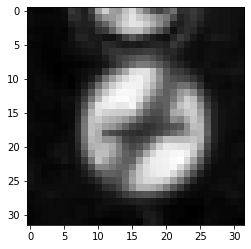

In [33]:
plt.imshow( color.rgb2gray(X_train[0]), cmap = plt.get_cmap('gray') )

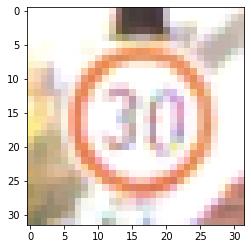

In [17]:
plt.imshow(X_test[400])

In [ ]:
!git add 